In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math

In [42]:
img = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)

In [43]:

h, w = img.shape
center = (w//2, h//2)
theta_1 = -50.0
theta_2 = 50.0
valor_maximo = -1.0
melhor_theta = -11.0
for theta in np.arange(theta_1, theta_2, 1):
    matriz_rotacao = cv2.getRotationMatrix2D(center, theta, 1)
    rotate_img = cv2.warpAffine(img, matriz_rotacao, (w, h), borderMode=cv2.BORDER_REPLICATE)
    perfil = []
    for i in range(h):
        perfil.append(np.sum(rotate_img[i]))
    soma = 0
    for i in range(h-1):
        soma += np.power(perfil[i+1] - perfil[i], 2)
    if (soma > valor_maximo):
        valor_maximo = soma
        melhor_theta = theta
print(melhor_theta)


26.0


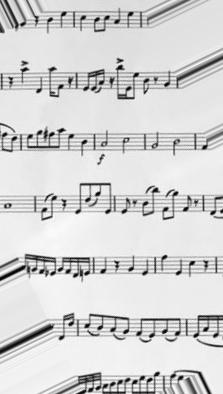

In [44]:

matriz = cv2.getRotationMatrix2D(center, melhor_theta, 1)
rotate_img = cv2.warpAffine(img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)

## PARTE 2

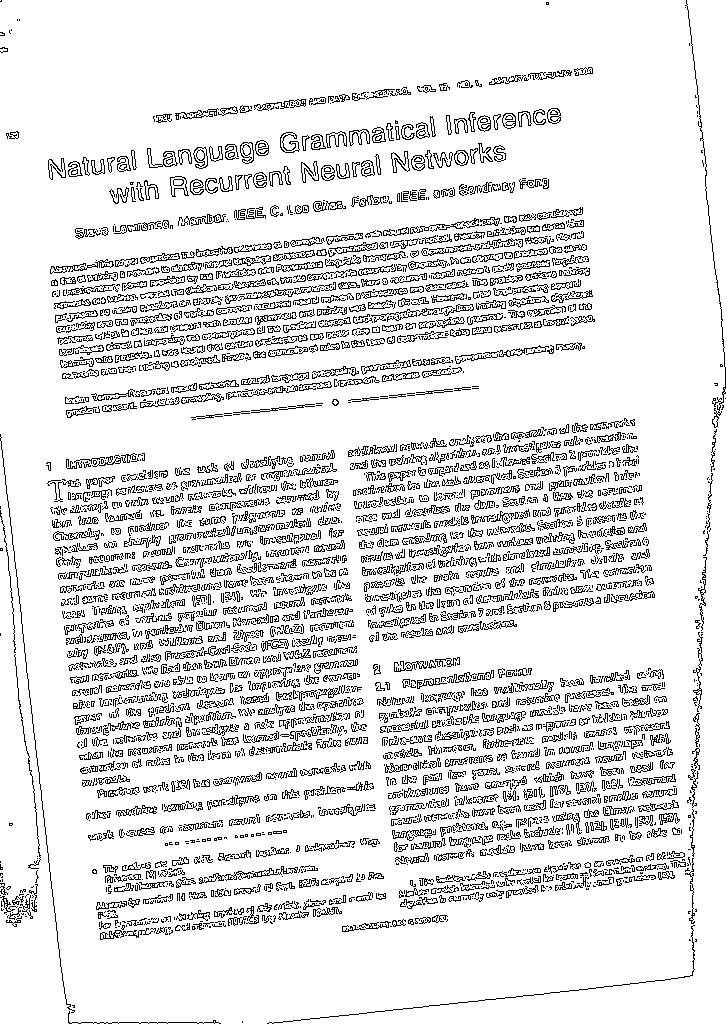

-6


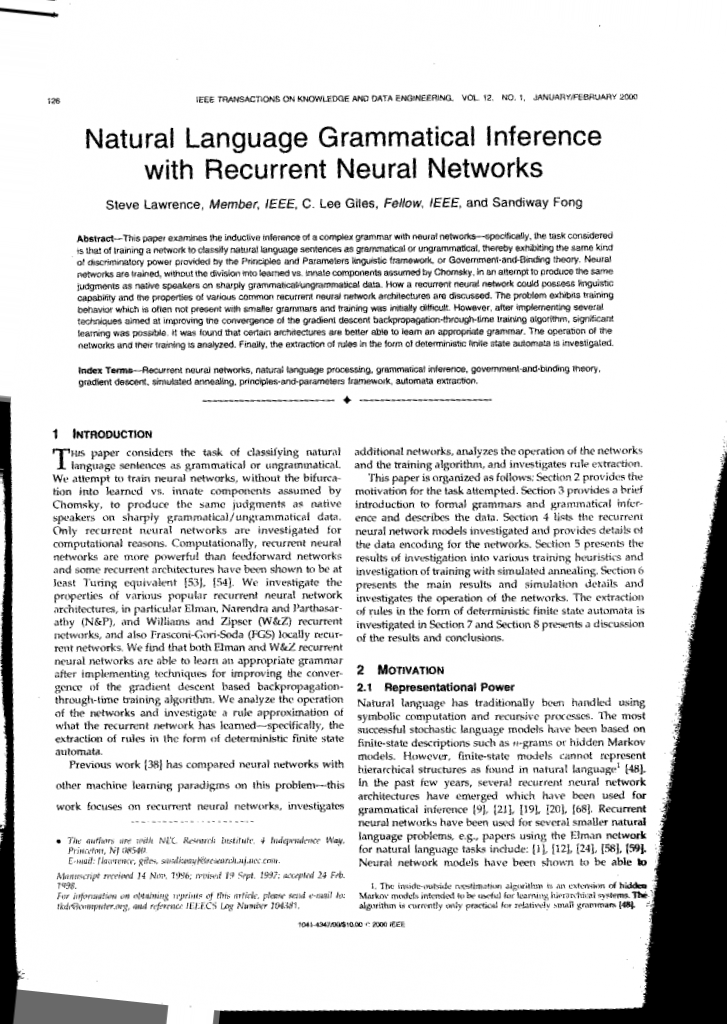

In [8]:

def fundo_branco(h, w, image):
    size = math.ceil(max(h, w) * math.sqrt(2)) # usando pensando no valor maximo que a diagonal maior pode ter
    new_image = np.zeros((size, size,), dtype=np.uint8)
    x_offset = (size - w) //2
    y_offset = (size - h) //2
    new_image[y_offset:y_offset+h, x_offset:x_offset + w] = image
    return new_image

def calcular_bins():
    d = np.sqrt(w**2+h**2)
    n = math.ceil(2 * d / delta)
    return n
img = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
# Usado canny ao inves de sobel porque sobel tinha bordas muito grossas o que ocasionava em um maior
# tempo de execução já que haveria muito mais pontos em preto
new_img = cv2.Canny(img, 100, 200)
new_img = fundo_branco(img.shape[0], img.shape[1], new_img)
# new_img = cv2.bitwise_not(new_img).astype(float)

cv2_imshow(new_img)

h, w = new_img.shape
maior_valor = -1
melhor_theta = 0
delta = 3
n_bins = calcular_bins()
offset = n_bins // 2
acumulador = [[0 for _ in range(n_bins)] for theta in range(181)]
seno = {theta:math.sin(math.radians(theta)) for theta in range(0, 181)}
cosseno = {theta:math.cos(math.radians(theta)) for theta in range(0, 181)}



def transformada_hough(x, y, theta):
    return round(x * cosseno[theta] + y * seno[theta],2)

for i in range(h):
    for j in range(w):
        if (new_img[i][j] == 0):
            continue
        for theta in range(0, 181):
            rho = int(transformada_hough(j , i, theta))
            idx_rho = offset + rho//delta
            acumulador[theta][idx_rho] += 1
for idx_theta, theta in enumerate(acumulador):
    for valor in theta:
        if (valor > maior_valor):
            melhor_theta = idx_theta
            maior_valor = valor
print(melhor_theta-90)

center = (w//2, h//2)
matriz = cv2.getRotationMatrix2D(center, melhor_theta-90, 1)
rotate_img = cv2.warpAffine(new_img, matriz, (w, h), borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotate_img)

In [ ]:
import sys
import cv2
import numpy as np
import math
from PIL import Image
import pytesseract
'''
Uso: python alinhar.py <caminho_entrada> <modo> <caminho_saida>
<modo>: projecao_horizontal ou transformada_hough
'''

def alinhar(path_entrada, modo):
    modos_validos = ['projecao_horizontal', 'transformada_hough']
    if modo not in modos_validos:
        raise ValueError(f"Modo inválido. Use um dos seguintes: {modos_validos}")

    if (modo == modos_validos[0]):
        return alinhar_projecao_horizontal(path_entrada)
    if (modo == modos_validos[1]):
        return alinhar_transformada_hough(path_entrada)
    return 0

def alinhar_projecao_horizontal(path_entrada):
    img = cv2.imread(path_entrada, cv2.IMREAD_GRAYSCALE)
    img = img.astype(float)
    h, w = img.shape
    center = (w//2, h//2)
    theta_1 = -90.0
    theta_2 = 90.0
    valor_maximo = -1.0
    melhor_theta = -1.0

    for theta in np.arange(theta_1, theta_2, 1):
        matriz_rotacao = cv2.getRotationMatrix2D(center, theta, 1)
        rotate_img = cv2.warpAffine(img, matriz_rotacao, (w, h), borderMode=cv2.BORDER_REPLICATE)
        perfil = []
        for i in range(h):
            perfil.append(np.sum(rotate_img[i]))
        soma = 0
        for i in range(h-1):
            soma += np.power(perfil[i+1] - perfil[i], 2)
        if (soma > valor_maximo):
            valor_maximo = soma
            melhor_theta = theta
    return rotacionar_imagem(img.astype(np.uint8), melhor_theta), melhor_theta

def alinhar_transformada_hough(path_entrada):
    img, new_img = ler_imagem_hough(path_entrada)
    h, w = new_img.shape
    maior_valor = -1
    melhor_theta = 0
    delta = 3
    n_bins = calcular_bins(delta, w, h)
    offset = n_bins // 2
    acumulador = [[0 for _ in range(n_bins)] for _ in range(181)]
    seno = {theta:math.sin(math.radians(theta)) for theta in range(0, 181)}
    cosseno = {theta:math.cos(math.radians(theta)) for theta in range(0, 181)}

    for i in range(h):
        for j in range(w):
            if (new_img[i][j] != 0):
                continue
            for theta in range(0, 181):
                cosseno_theta = cosseno[theta]
                seno_theta = seno[theta]
                rho = int(transformada_hough(j , i, cosseno_theta, seno_theta))
                idx_rho = offset + rho//delta
                acumulador[theta][idx_rho] += 1
    for idx_theta, theta in enumerate(acumulador):
        for valor in theta:
            if (valor > maior_valor):
                melhor_theta = idx_theta
                maior_valor = valor
    return rotacionar_imagem(img, melhor_theta-90), melhor_theta - 90


def ler_imagem_hough(path_entrada):
    img = cv2.imread(path_entrada, cv2.IMREAD_GRAYSCALE)
    # Usado canny ao inves de sobel porque sobel tinha bordas muito grossas o que ocasionava em um maior
    # tempo de execução já que haveria muito mais pontos em preto
    new_img = cv2.Canny(img, 100, 200)
    new_img = cv2.bitwise_not(new_img).astype(float)
    return img, new_img

def calcular_bins(delta, w, h):
    d = np.sqrt(w**2+h**2)
    n = math.ceil(2 * d / delta)
    return n

def transformada_hough(x, y, cosseno_theta, seno_theta):
    return round(x * cosseno_theta + y * seno_theta,2)

def rotacionar_imagem(image, melhor_theta):
    image = fundo_branco(image)
    h, w = image.shape
    center = (w//2, h//2)
    matriz = cv2.getRotationMatrix2D(center, melhor_theta, 1)
    rotate_img = cv2.warpAffine(image, matriz, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotate_img
def fundo_branco(image):
    h, w = image.shape
    size = math.ceil(max(h, w) * math.sqrt(2)) # usando pensando no valor maximo que a diagonal maior pode ter
    new_image = np.ones((size, size,), dtype=np.uint8) * 255
    x_offset = (size - w) //2
    y_offset = (size - h) //2
    new_image[y_offset:y_offset+h, x_offset:x_offset + w] = image
    return new_image



def confianca_ocr(caminho_imagem):
    img = Image.open(caminho_imagem)
    dados = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    confiancas = []
    for i in range(len(dados['text'])):
        texto = dados['text'][i].strip()
        conf = int(dados['conf'][i])
        if texto and conf != -1:
            confiancas.append(conf)

    if confiancas:
        media_confianca = sum(confiancas) / len(confiancas)
    else:
        media_confianca = 0

    return media_confianca

if __name__ == '__main__':
    try:
        if len(sys.argv) != 4:
            print("Uso: python alinhar.py <caminho_entrada> <modo> <caminho_saida>")
            sys.exit(1)

        entrada = sys.argv[1]
        modo = sys.argv[2]
        saida = sys.argv[3]

        rotate_img, theta = alinhar(entrada, modo)
        print(f'Angulo utilizado para alinhar a imagem: {theta}°')
        cv2.imwrite(saida, rotate_img)
        # confianca_entrada = confianca_ocr(entrada)
        # confianca_saida = confianca_ocr(saida)
        # print(f"Confianca entrada: {confianca_entrada}")
        # print(f"Confianca saida: {confianca_saida}")
    except Exception as e:
        print(f"Erro: {e}")
        sys.exit(1)